In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt



In [ ]:
data = pd.read_csv('/content/dataset_extreme.csv')
features = ['feature1', 'feature2', 'feature3']
X = data[features].values
y = data['VPN'].values

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [ ]:
# Step 5: Create a DataLoader for the dataset
class BinaryClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
# Step 6: Define a neural network architecture
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.layer3(x))
        return x

In [ ]:
# Step 7: Train the model and evaluate it using cross-validation
val_loss_cv = []
val_acc_cv = []
train_acc_epoch_cv = []
val_acc_epoch_cv = []
train_f1_epoch_cv = []
val_f1_epoch_cv = []
val_precision_epoch_cv = []
val_recall_epoch_cv = []

val_true_labels = []
val_scores = []

for train_index, val_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    train_dataset = BinaryClassificationDataset(X_train, y_train)
    val_dataset = BinaryClassificationDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    model = BinaryClassifier(X_train.shape[1]).cuda()

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 50
    train_acc_epoch = []
    val_acc_epoch = []
    train_f1_epoch = []
    val_f1_epoch = []
    val_precision_epoch = []
    val_recall_epoch = []
    val_true_labels_fold = []
    val_scores_fold = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        y_true_train = []
        y_pred_train = []
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            predicted_train = (outputs > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(predicted_train.cpu().numpy())


        train_acc_epoch.append(correct_train / total_train * 100)
        train_f1_epoch.append(f1_score(y_true_train, y_pred_train))

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        y_true_val = []
        y_pred_val = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.cuda(), labels.cuda()
                outputs = model(inputs).squeeze()

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                y_true_val.extend(labels.cpu().numpy())
                y_pred_val.extend(predicted.cpu().numpy())
                val_true_labels_fold.extend(labels.cpu().numpy())
                val_scores_fold.extend(outputs.cpu().numpy())

        val_acc_epoch.append(correct / total * 100)
        val_f1_epoch.append(f1_score(y_true_val, y_pred_val))
        # Calculate precision and recall for this epoch
        precision, recall, _ = precision_recall_curve(y_true_val, y_pred_val)
        val_precision_epoch.append(np.mean(precision))
        val_recall_epoch.append(np.mean(recall))

    train_acc_epoch_cv.append(train_acc_epoch)
    val_acc_epoch_cv.append(val_acc_epoch)
    train_f1_epoch_cv.append(train_f1_epoch)
    val_f1_epoch_cv.append(val_f1_epoch)
    val_precision_epoch_cv.append(val_precision_epoch)
    val_recall_epoch_cv.append(val_recall_epoch)
    val_true_labels.append(val_true_labels_fold)
    val_scores.append(val_scores_fold)

    val_loss_cv.append(val_loss / len(val_loader))
    val_acc_cv.append(correct / total * 100)

# Print average validation loss and accuracy over all folds
# Print average validation accuracy, F1-score, precision, and recall over all folds
print(f"Average Validation Accuracy: {np.mean(val_acc_cv)/100}")
print(f"Average Validation F1-score: {np.mean(val_f1_epoch_cv, axis=0)[-1]}")
print(f"Average Validation Precision: {np.mean(val_precision_epoch_cv, axis=0)[-1]}")
print(f"Average Validation Recall: {np.mean(val_recall_epoch_cv, axis=0)[-1]}")


Average Validation Accuracy: 0.9771604938271605
Average Validation F1-score: 0.9664356537094904
Average Validation Precision: 0.7631728164072797
Average Validation Recall: 0.6592592592592592


In [ ]:
# Compute the average training and validation accuracy and F1-score over all folds
train_acc_epoch_mean = np.mean(train_acc_epoch_cv, axis=0)
val_acc_epoch_mean = np.mean(val_acc_epoch_cv, axis=0)
train_f1_epoch_mean = np.mean(train_f1_epoch_cv, axis=0)
val_f1_epoch_mean = np.mean(val_f1_epoch_cv, axis=0)
val_precision_epoch_mean = np.mean(val_precision_epoch_cv, axis=0)
val_recall_epoch_mean = np.mean(val_recall_epoch_cv, axis=0)


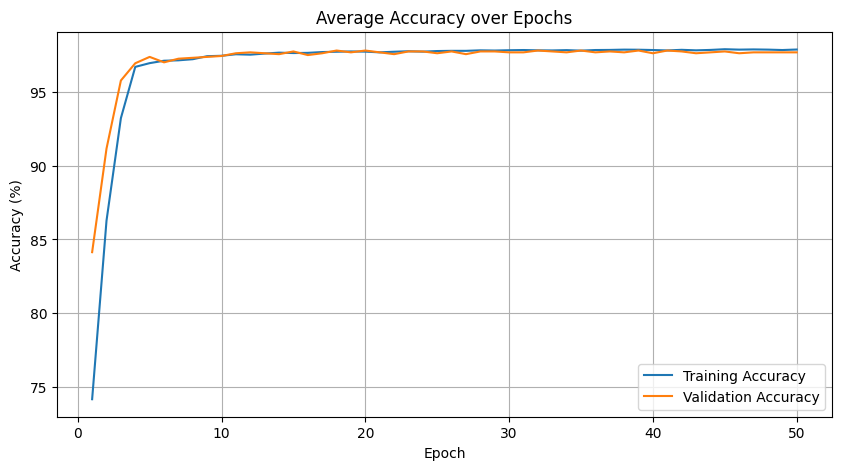

In [ ]:
# Plot average accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_acc_epoch_mean, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_epoch_mean, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Average Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()

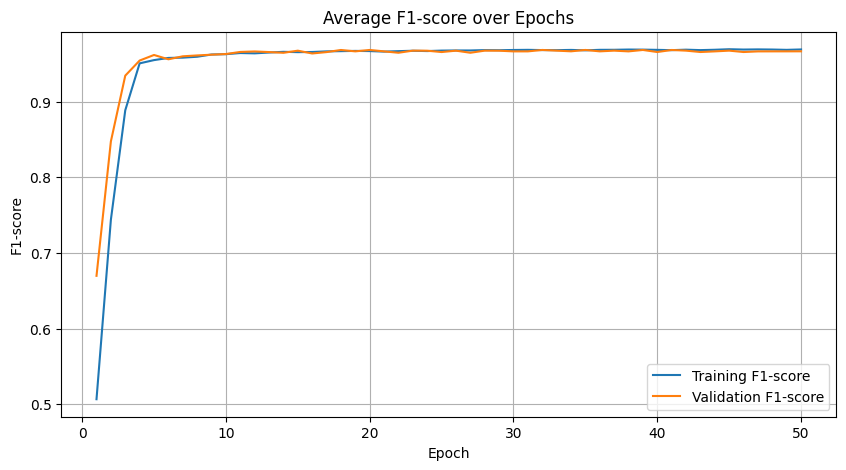

In [ ]:
# Plot average F1-score over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_f1_epoch_mean, label='Training F1-score')
plt.plot(range(1, num_epochs + 1), val_f1_epoch_mean, label='Validation F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('Average F1-score over Epochs')
plt.legend()
plt.grid()
plt.show()

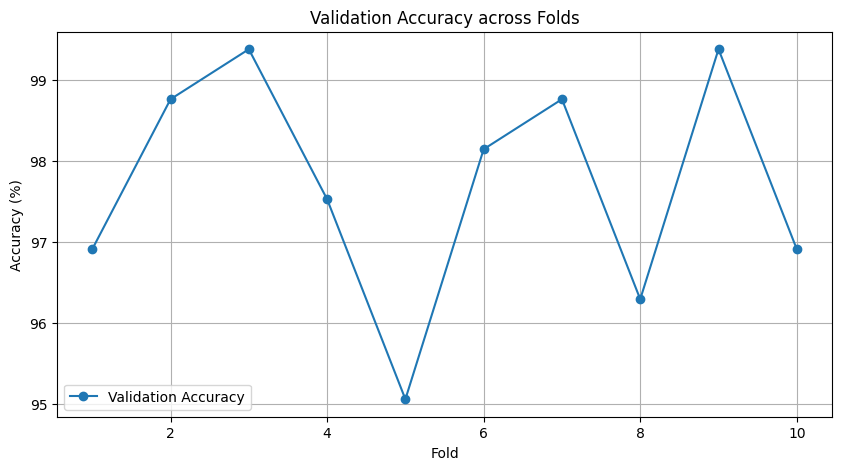

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_splits + 1), val_acc_cv, marker='o', label='Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy across Folds')
plt.legend()
plt.grid()
plt.show()

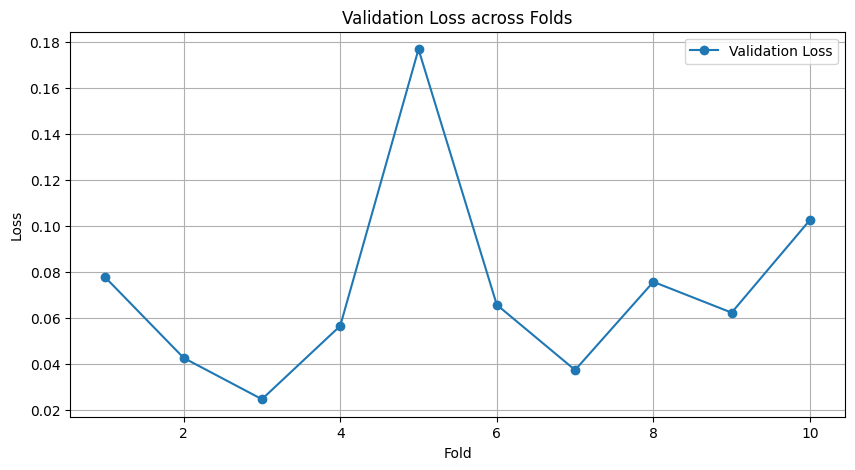

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_splits + 1), val_loss_cv, marker='o', label='Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('Validation Loss across Folds')
plt.legend()
plt.grid()
plt.show()

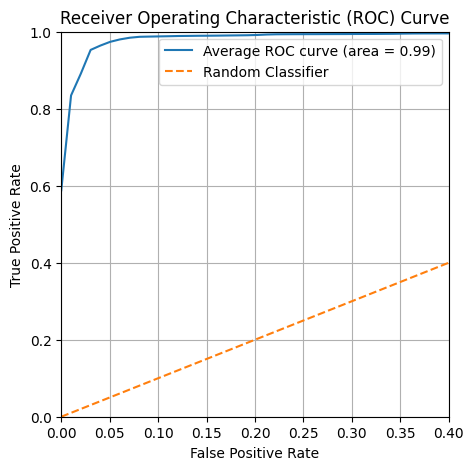

In [ ]:
from scipy.interpolate import interp1d

# Compute ROC curve and AUC
tpr_cv = []
fpr_cv = []
auc_cv = []
mean_fpr = np.linspace(0, 1, 100)

for fold in range(n_splits):
    y_true_val = np.array(val_true_labels[fold])
    y_score_val = np.array(val_scores[fold])
    fpr, tpr, _ = roc_curve(y_true_val, y_score_val)
    auc_score = auc(fpr, tpr)

    tpr_interp = interp1d(fpr, tpr, kind='linear', fill_value=(0, 1), bounds_error=False)
    tpr_cv.append(tpr_interp(mean_fpr))
    auc_cv.append(auc_score)

# Compute the average TPR and AUC over all folds
tpr_mean = np.mean(tpr_cv, axis=0)
auc_mean = np.mean(auc_cv)

# Plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(mean_fpr, tpr_mean, label=f'Average ROC curve (area = {auc_mean:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 0.4)  # Set x-axis limits from 0 to 0.4
plt.show()



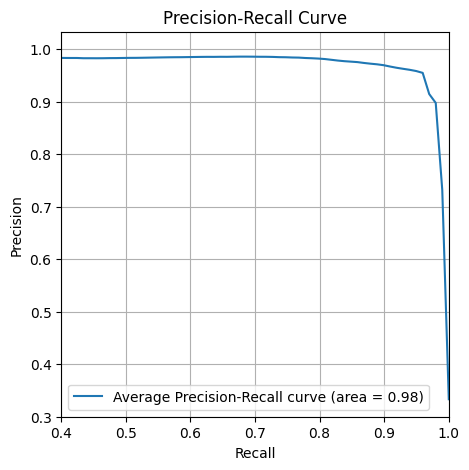

In [ ]:
from scipy.interpolate import interp1d

# Compute Precision-Recall curve and average precision
precision_cv = []
recall_cv = []
average_precision_cv = []
mean_recall = np.linspace(0, 1, 100)

for fold in range(n_splits):
    y_true_val = np.array(val_true_labels[fold])
    y_score_val = np.array(val_scores[fold])
    precision, recall, _ = precision_recall_curve(y_true_val, y_score_val)
    average_precision = average_precision_score(y_true_val, y_score_val)

    precision_interp = interp1d(recall[::-1], precision[::-1], kind='linear', fill_value=(0, 1), bounds_error=False)
    precision_cv.append(precision_interp(mean_recall))
    average_precision_cv.append(average_precision)

# Compute the average Precision and Recall over all folds
precision_mean = np.mean(precision_cv, axis=0)
average_precision_mean = np.mean(average_precision_cv)

# Plot Precision-Recall curve
plt.figure(figsize=(5, 5))
plt.plot(mean_recall, precision_mean, label=f'Average Precision-Recall curve (area = {average_precision_mean:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.xlim(0.4, 1)
plt.show()

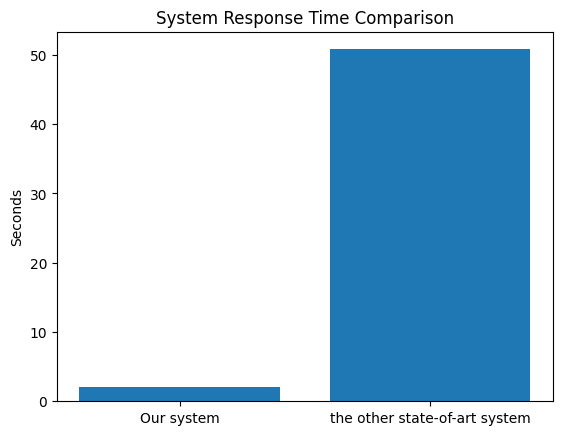

In [ ]:
import matplotlib.pyplot as plt

response_times = [2.00, 50.79]
labels = ['Our system', 'the other state-of-art system']

plt.bar(labels, response_times)
plt.ylabel('Seconds')
plt.title('System Response Time Comparison')

plt.show()

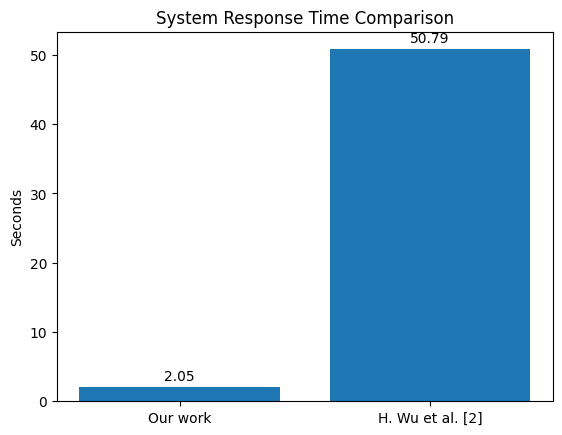

In [ ]:
import matplotlib.pyplot as plt

response_times = [2.05, 50.79]
labels = ['Our work', 'H. Wu et al. [2]']

# Create the bar plot
bars = plt.bar(labels, response_times)

# Function to add value labels above the bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(
            f'{height}',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords='offset points',
            ha='center',  # Horizontal alignment
            va='bottom'  # Vertical alignment
        )

add_value_labels(bars)

plt.ylabel('Seconds')
plt.title('System Response Time Comparison')

plt.show()






